In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [9]:
import nevergrad as ng
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [1]:
from helper import load_model, data, labels

## Introduction

The goal of this notebook is to implement the envisioned artifact for the generation of coherent explanations on the synthetic dataset that was used in Poyiazdi et al. (2019) *FACE: Feasible and Actionable Counterfactual Explanations* to (visually) compare different approaches.

We have a synthetic data set as in Poyiazdi et al. (2019):

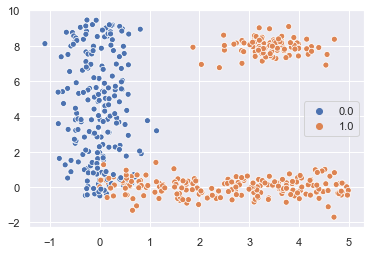

In [3]:
sns.scatterplot(data.transpose()[0], data.transpose()[1], hue=labels)

Again, exactly as in Poyiazdi et al. (2019) we trained a dense neural network with two hidden layers:

In [4]:
model = load_model()

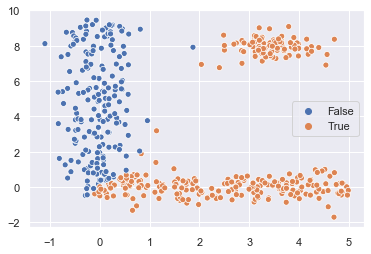

In [7]:
sns.scatterplot(data.transpose()[0], data.transpose()[1], hue=model.predict(data).reshape((500,)) > 0.5)

Note that (at least at the time writing this notebook) the data set is re-generated every time it is loaded, so it's expected that the neural network (which was hence trained on different, equally small dataset) is not 100% accurate.

## Kernel density estimation

We estimate the density based on the dataset:

In [12]:
kde = KDEMultivariate(data, var_type="cc")
kde.bw

array([0.65640624, 1.35212695])

Check that it indeed fits the data:

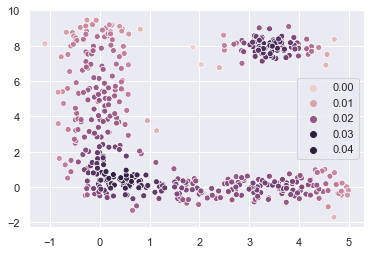

In [13]:
sns.scatterplot(data.transpose()[0], data.transpose()[1], hue=kde.pdf(data))

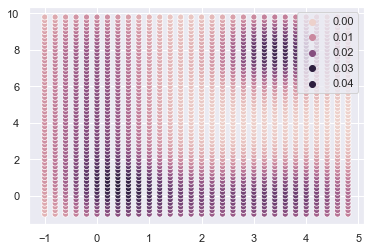

In [18]:
grid = np.array([[x/5, y/5] for x in range(-5, 25) for y in range(-5, 50)])
sns.scatterplot(grid.transpose()[0], grid.transpose()[1], hue=kde.pdf(grid))

## Assemble the objective function

At the heart of our artifact the objective function measures the distance between the model's output and the intended target as well as the density:

In [67]:
EPSILON = 1e-9
def make_objective_function(target_class, class_distance=2, alpha=1.0):
    def objective(x, y):
        sample = np.array([x, y])

        first_term = np.power(model.predict(sample.reshape((1, -1)))[0][0] - target_class, class_distance)
        
        second_term = alpha * (1/(kde.pdf(sample) + EPSILON))
        
        return first_term + second_term
    
    return objective

## Implement the artifact

In [147]:
def find_counterfactual(fact, class_distance=2, alpha=1.0):
    fact_class = 1 if model.predict(fact.reshape((-1, 2)))[0] > 0.5 else 0
    foil_class = 1 - fact_class
    print(f"Fact class {fact_class} to foil class {foil_class}.")
    
    var_x = ng.p.Scalar(fact[0], mutable_sigma=False)
    var_x.set_mutation(sigma=kde.bw[0]/10)
    var_x.set_bounds(-1, 5, method="constraint")

    var_y = ng.p.Scalar(fact[1], mutable_sigma=False)
    var_y.set_mutation(sigma=kde.bw[1]/10)
    var_y.set_bounds(-1, 10, method="constraint")
    
    instrumentation = ng.p.Instrumentation(var_x, var_y)
    
    optimizer = ng.optimizers.OnePlusOne(parametrization=instrumentation, budget=200)
    
    objective = make_objective_function(foil_class, class_distance, alpha)
    
    results = optimizer.minimize(objective)
    
    return results[0]    

## Test the artifact

In [167]:
def plot(fact, foils):
    df = pd.DataFrame(
    {
        "x": np.hstack([data.transpose()[0], fact[0], foil[0]]),
        "y": np.hstack([data.transpose()[1], fact[1], foil[1]]),
        "label": np.hstack([labels, model.predict(fact.reshape((-1, 2)))[0], model.predict(foil.reshape((-1, 2)))[0]]),
        "style": np.hstack([np.zeros_like(labels), [1], [2]]),
        "size": np.hstack([np.ones_like(labels), [5], [5]])
    })
    fig, ax = plt.subplots(figsize=(10.0, 7.0))
    g = sns.scatterplot("x", "y", hue="label", style="style", size="size", data=df, ax=ax, palette="bright")
    _ = g.legend().remove()

We can now try the artifact for different values of *alpha*:

Fact class 0 to foil class 1.


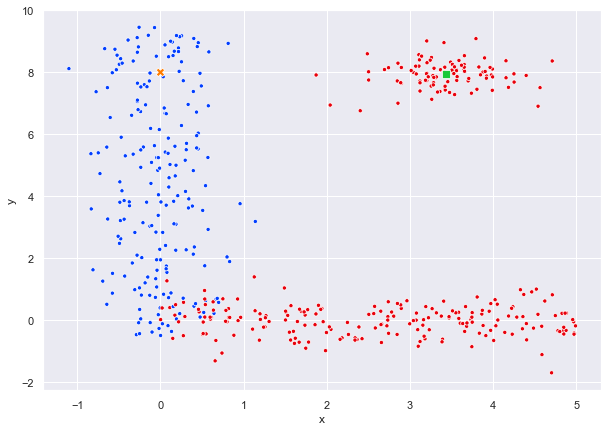

In [169]:
fact = np.array([0, 8])
best_parameters = find_counterfactual(fact, alpha=0.0001)
foil = np.array([best_parameters[0].value, best_parameters[1].value])
plot(fact, foil)

Fact class 0 to foil class 1.


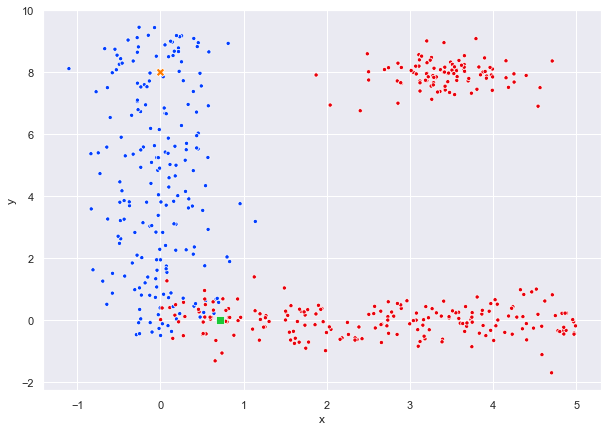

In [170]:
fact = np.array([0, 8])
best_parameters = find_counterfactual(fact, alpha=0.01)
foil = np.array([best_parameters[0].value, best_parameters[1].value])
plot(fact, foil)

Fact class 0 to foil class 1.


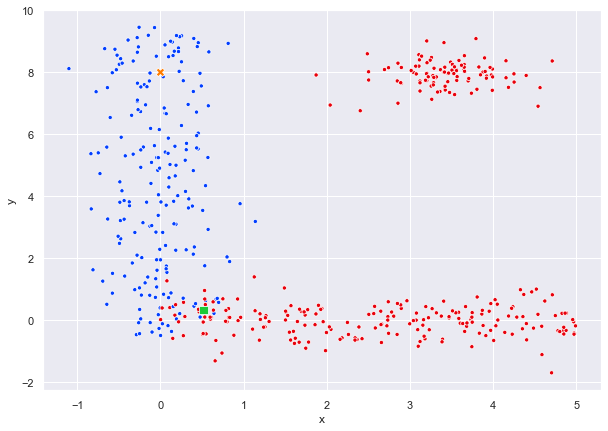

In [171]:
fact = np.array([0, 8])
best_parameters = find_counterfactual(fact, alpha=0.1)
foil = np.array([best_parameters[0].value, best_parameters[1].value])
plot(fact, foil)

This looks like it's working!